# Demonstration RAG-Eval


In [1]:
from rag_eval.protocol import LLMClient
from rag_eval.client import AzureClient
from rag_eval.components import ClaimExtractor, EntailmentJudge
from rag_eval.data_models import EvalContainer, ClaimVerdict
from rag_eval.evaluators import AnswerPrecisionEvaluator, RetrievalPrecisionEvaluator
from rag_eval.coordinator import RAGEvaluator
from rag_eval.helpers import _safe_json
import json
from data.rag_eval_samples import test_examples
from openai import AzureOpenAI
from dotenv import load_dotenv
import os

c:\Users\ANDERBE\AI-Agent-POC-git\AI-Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# Test Agent

Check if agent module actually works.

In [3]:
# load agent and pipeline for indexing docs
import agent.main as main
from rag.indexing import pdf_files, index_pipeline

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


In [4]:
index_pipeline.run({"converter": {"sources": pdf_files}})

incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
incorrect startxref pointer(1)
parsing for Object Streams
Batches: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


{'writer': {'documents_written': 51}}

## RAG-Loop
Loop which passes questions to agent and extracts generated answers alongside retrieved contexts (plain text). Combines them with ground truth and query to form `EvalContainer`-object.

In [5]:
# quick test of my query_gt_extractor function
from src.rag_eval.helpers import query_gt_extractor

queries, gt = query_gt_extractor(path="data/agent_eval_questions.json", tokenize=False)
print(len(queries), len(gt))


40 40


This code cell creates a RAG-loop for the agent. It:  
- feeds the questions from the test battery to the agent  
- extracts the generated answer and retrieved context from the RAG-call
- returns a list of `EvalContainer`-objects storing question, ground truth, generated answer and retrieved context

It thus lays the foundation for the `RAGEevaluator`. 

In [5]:
main.food_agent(user_input="Vergleiche den Preis für Espresso von Anton's Pizza und bei Il sogno de Anton. Wo ist Espresso teurer?")


▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Espresso Preis bei Anton's Pizza","top_k":3}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 28.74it/s]


Top K is: 3
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 74.47it/s]


Top K is: 3
(['Natürlich! Hier sind die Speisekarten der beiden Restaurants aus dem gegebenen Kontext:\n\n---\n\n**Chez Anton – Délices Canins**\n\n*Entrées (Vorspeisen)*  \n- Croquettes d’Appétit (Knusprige Bällchen) – 5,50 €  \n- Pain à l’Ail Canin (Knoblauchbrot) – 4,00 €  \n- Salade du Chien Heureux (gemischter Salat) – 6,00 €  \n- Soupe du Terrier (hausgemachte Suppe) – 5,00 €  \n\n*Plats principaux (Hauptgerichte)*  \n- Boeuf Bourguignon du Chien – 14,50 €  \n- Coq au Vin Canin – 13,00 €  \n- Gratin de Patte (Kartoffelgratin) – Preis nicht angegeben  \n\n---\n\n**Tönis Tacos**\n\n*Vorspeisen*  \n- Guacamole mit Tortilla-Chips – 5,50 €  \n- Quesadillas mit Käse und Jalapeños – 6,00 €  \n- Mexikanische Bohnen-Suppe – 4,50 €  \n- Elote (gegrillter Mais mit Limette und Käse) – 5,00 €  \n\n*Tacos*  \n- Carne Asada Taco (Rindfleisch, Zwiebeln, Koriander) – 3,50 €  \n- Pollo Taco (gegrilltes Hähnchen, Pico de Gallo) – 3,50 €  \n- Veggie Taco (gegrilltes Gemüse, Avocado) – Preis nicht an

{'result': (['Natürlich! Hier sind die Speisekarten der beiden Restaurants aus dem gegebenen Kontext:\n\n---\n\n**Chez Anton – Délices Canins**\n\n*Entrées (Vorspeisen)*  \n- Croquettes d’Appétit (Knusprige Bällchen) – 5,50 €  \n- Pain à l’Ail Canin (Knoblauchbrot) – 4,00 €  \n- Salade du Chien Heureux (gemischter Salat) – 6,00 €  \n- Soupe du Terrier (hausgemachte Suppe) – 5,00 €  \n\n*Plats principaux (Hauptgerichte)*  \n- Boeuf Bourguignon du Chien – 14,50 €  \n- Coq au Vin Canin – 13,00 €  \n- Gratin de Patte (Kartoffelgratin) – Preis nicht angegeben  \n\n---\n\n**Tönis Tacos**\n\n*Vorspeisen*  \n- Guacamole mit Tortilla-Chips – 5,50 €  \n- Quesadillas mit Käse und Jalapeños – 6,00 €  \n- Mexikanische Bohnen-Suppe – 4,50 €  \n- Elote (gegrillter Mais mit Limette und Käse) – 5,00 €  \n\n*Tacos*  \n- Carne Asada Taco (Rindfleisch, Zwiebeln, Koriander) – 3,50 €  \n- Pollo Taco (gegrilltes Hähnchen, Pico de Gallo) – 3,50 €  \n- Veggie Taco (gegrilltes Gemüse, Avocado) – Preis nicht ang

In [12]:
from src.rag_eval.eval_loop import rag_loop_agent

# commented out because I save the resulting data object to avoid frequent execution
result, failures = rag_loop_agent()

lens: 40 40

▶️ Step 1: thinking…
TOOL CALL ▶ execute_agentic_rag {"question":"Wie viel kostet der Espresso bei Anton's Pizza und wie viel bei Il sogno de Anton? Welches Restaurant verlangt mehr für den Espresso?"}
Invoked agentic RAG!


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.24it/s]


(["Der Espresso kostet bei Anton's Pizza 2,00 € und bei Il sogno de Anton ebenfalls 2,00 €. Beide Restaurants verlangen also den gleichen Preis für den Espresso."], [["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €\nDoggish Special (Tomate, Mozzarella, Rinderhack, Speck, Zwiebeln) - 11,50 €\nFunghi (Tomate, Mozzarella, Champignons) - 9,50 €\nVeggie Delight (Tomate, ", 'Tönis Tacos\nVorspeisen\nGuacamole mit Tortilla-Chips - 5,50 €\nQuesadillas mit Käse und Jalapeños - 6,00 €\nMexikanische Bohnen-Suppe - 4,50 €\nElote – gegrillter Mais mit Limette und Käse - 5,00 €\nTacos\nCarne Asada Taco (Rindfleisch, Zwiebeln, Koriander) - 3,50 €\nPollo Taco (gegrilltes Hähnchen, Pico de Gallo) - 3,50 €\nVeggie Taco (gegrilltes Gemüse, Avocado) - ', 'Chez Anton - Délic

Batches: 100%|██████████| 1/1 [00:00<00:00, 15.94it/s]


(["Die Restaurants, die Risotto anbieten, sind:\n\n1. Anton's Pizza - Doggish Delights\n2. Il sogno de Anton - Cucina Raffinata & Doggish Flair\n\n**Preise (laut Kontext):**\n- Bei Anton's Pizza - Doggish Delights:\n  - Risotto ai Funghi (mit Pilzen) – **11,50 €**\n  - Meeresfrüchte-Risotto – **14,00 €**\n  - Risotto Primavera (Gemüse der Saison) – **12,00 €**\n\n- Bei Il sogno de Anton (Preise für Risotto im Kontext nicht genannt, daher werden hier die Preise von Anton's Pizza - Doggish Delights verwendet).\n\n**Unterschied zwischen günstigstem und teuerstem Risotto:**  \nDas günstigste Risotto ist das Risotto ai Funghi für **11,50 €**, das teuerste das Meeresfrüchte-Risotto für **14,00 €**.\n\n**Preisunterschied:**  \n**14,00 € – 11,50 € = 2,50 €**\n\n**Zusammenfassung:**  \nDie Restaurants Anton's Pizza (und ggf. Il sogno de Anton) bieten Risotto an. Der Preisunterschied zwischen dem günstigsten und teuersten Risotto beträgt **2,50 €**."], [["Mozzarella, Paprika, Zucchini, Oliven) -

Batches: 100%|██████████| 1/1 [00:00<00:00, 28.87it/s]


(['Ein klassisches französisches Menü besteht traditionell aus mehreren, systematisch aufeinanderfolgenden Gängen. Typisch ist folgende Menüstruktur:\n\n1. **Entrée (Vorspeise):** Ein leichter Gang wie Salat, Pastete oder Suppe, der den Appetit anregt.\n2. **Plat principal (Hauptgericht):** Fleisch, Fisch oder Geflügel mit passenden Beilagen.\n3. **Fromage (Käse):** Ein spezieller Gang mit verschiedenen Käsesorten, der meist nach dem Hauptgericht folgt.\n4. **Dessert:** Süßspeisen wie Crème brûlée, Mousse au Chocolat oder Tarte Tatin.\n(Manchmal gibt es noch einen zusätzlichen Fischgang, Sorbet als Zwischengang oder eine Salatkomponente.)\nAußerdem sind Brot und regionalpassende Butter feste Bestandteile.\n\n**Die Rolle des Weins in der französischen Menüfolge:**\nWein spielt in Frankreich eine zentrale und zelebrierte Rolle. Er wird sorgfältig zu den einzelnen Gängen passend ausgewählt: Weißwein zu leichten Vorspeisen oder Fisch, Rotwein zu kräftigen Fleischgerichten, Dessertweine ode

Batches: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s]


(['Für die französische Esskultur wird das „Gastronomische Mahl der Franzosen“ („Le repas gastronomique des Français“) als immaterielles UNESCO-Weltkulturerbe genannt. Diese Auszeichnung stammt aus dem Jahr 2010.\n\nAuch die mexikanische Küche wurde 2010 von der UNESCO als immaterielles Weltkulturerbe („Immaterielles Kulturerbe der Menschheit“) ausgezeichnet.'], [['Frankreich Weltspitze mit Regionen wie Bordeaux,\nBurgund oder Champagne. Die Esskultur ist Teil des immateriellen UNESCO-Weltkulturerbes - mit\nRitualen, Gaengen und Bedeutung fuer das gesellschaftliche Leben.', 'Langgaren in Erdöfen (z. B. bei Barbacoa) sind tief verwurzelte Traditionen.\nSüßspeisen wie Flan, Tres Leches oder Churros spiegeln ebenfalls die spanischen Einflüsse wider,\nwurden aber mexikanisch weiterentwickelt. Die Getränkekultur umfasst neben Bier und Tequila auch\nMezcal, Horchata (Reis-Zimt-Getränk) und Agua Fresca (Fruchtwasser).\n2010 wurde die mexikanische Küche von der UNESCO als immaterielles Weltkul

Batches: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


(['**Antwort:**\n\nDrei Grundpfeiler der mexikanischen „heiligen Fünf“ sind **Mais, Bohnen und Chili**.\n\nDiese Grundnahrungsmittel prägen die mexikanische Küche bis heute und bildeten bereits in präkolumbianischer Zeit die Basis vieler Gerichte.\n\nIm Vergleich dazu gehören zu den Grundpfeilern der italienischen Küche **Oliven/Olivenöl** und **Getreide** (vor allem in Form von Pasta und Brot).\n\n**Beziehung:**\n\nSowohl Mais (Mexiko) als auch Getreide (Italien) sind zentrale Sättigungsbeilagen in ihren jeweiligen Küchen und Grundlage zahlreicher typischer Speisen (z.B. Tortillas vs. Pasta/Brot). Bohnen – als pflanzliche Eiweißquelle – spielen in beiden Küchen eine wichtige Rolle (z.B. mexikanische Bohnengerichte, italienische Pasta e Fagioli). Chili als charakteristische Würze der mexikanischen Küche steht in gewisser Weise dem in Italien üblichen, aromatischen Verwenden von Olivenöl gegenüber, das weniger scharf, aber ebenso prägend für den Geschmack ist.\n\n**Zusammenfassung:**  \

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


(['Im gegebenen Kontext werden Speisen und Menüs der Restaurants „Il sogno de Anton“ (italienisch) und „Chez Anton – Délices Canins“ (französisch) aufgelistet, unter anderem mit Preisen für die einzelnen Gerichte. Allerdings finden sich in den Textauszügen keine direkten Angaben zu den Preisen von Prosecco im „Il sogno de Anton“ oder zu französischem Rotwein im „Chez Anton“. Nur Speisenpreise (z. B. Pasta, Fleischgerichte, Antipasti) werden genannt, jedoch keine Angaben zu Getränkepreisen.\n\n**Antwort:**  \nIm vorliegenden Kontext sind weder der Preis von Prosecco bei "Il sogno de Anton" noch der Preis für französischen Rotwein bei "Chez Anton" konkret angegeben, sodass ein Preisvergleich nicht möglich ist.'], [['wie Rom, Florenz, Venedig und Mailand ziehen jedes Jahr Millionen Besucher\nan. Die italienische Lebensweise, das "Dolce Vita", zeichnet sich durch Genuss, Stilbewusstsein\nund familiaere Werte aus. Die Landschaft reicht von den schneebedeckten Alpen im Norden ueber\ndie Seen

Batches: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s]


(['Bei Tönis Tacos gibt es folgende Taco-Varianten:\n\n- Carne Asada Taco (Rindfleisch, Zwiebeln, Koriander)\n- Pollo Taco (gegrilltes Hähnchen, Pico de Gallo)\n- Veggie Taco (gegrilltes Gemüse, Avocado)\n- Fish Taco (gebratener Fisch, Krautsalat)\n\nDas Grundelement, das laut der Beschreibung der mexikanischen Küche in allen Tacos steckt, ist die **Tortilla aus Mais**. Die traditionsreiche Nutzung von Mais und Tortillas bildet die Basis vieler klassischer mexikanischer Speisen wie Tacos.'], [['Tönis Tacos\nVorspeisen\nGuacamole mit Tortilla-Chips - 5,50 €\nQuesadillas mit Käse und Jalapeños - 6,00 €\nMexikanische Bohnen-Suppe - 4,50 €\nElote – gegrillter Mais mit Limette und Käse - 5,00 €\nTacos\nCarne Asada Taco (Rindfleisch, Zwiebeln, Koriander) - 3,50 €\nPollo Taco (gegrilltes Hähnchen, Pico de Gallo) - 3,50 €\nVeggie Taco (gegrilltes Gemüse, Avocado) - ', '3,00 €\nFish Taco (gebratener Fisch, Krautsalat) - 4,00 €\nBurritos\nClassic Burrito mit Reis, Bohnen und Rindfleisch - 8,00 €

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s]


(['Laut der Küchenbeschreibung gelten Tiramisu und Panna Cotta als zwei typische italienische Desserts. Allerdings handelt es sich bei der angegebenen Speisekarte nicht um die Karte von "Il sogno de Anton", sondern um die des fiktiven Lokals "Chez Anton - Délices Canins", das französisch angehaucht ist und auf Hunde ausgerichtet zu sein scheint. Auf dieser Karte finden sich Desserts wie "Gaufres du Chiot", "Mousse au Chocolat Canin", "Tartelette aux Biscuits" und "Crème Brûlée de la Queue". Weder Tiramisu noch Panna Cotta stehen auf dieser Karte.\n\n**Antwort:**  \nTypisch italienisch sind Tiramisu und Panna Cotta. Auf der angegebenen Karte von Chez Anton ("Il sogno de Anton" ist nicht enthalten) findest du jedoch keines der beiden Desserts.'], [['fuer feine Zutaten,\nausgekluegelte Technik und jahrhundertealte Traditionen. Bereits im 17. Jahrhundert praegten\nkoenigliche Hofkoeche Grundlagen moderner Kochkunst. Begriffe wie "Sauce Bechamel", "Mise en\nPlace" oder "Degustation" stammen

Batches: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


(['Laut dem Cocktail-Dokument gelten Cocktails wie Martini, Manhattan, Margarita und Daiquiri als Klassiker.\n\nIn den gegebenen Speisekarten und Kontexten der Restaurants ist kein direkter Cocktailverkauf mit Preis aufgeführt – die Menüs zeigen hauptsächlich Speisen (wie beim italienischen und französischen Restaurant) und keine eigenen Cocktailkarten. Daher kann kein Restaurant aus dem Kontext explizit als Verkäufer eines dieser klassischen Cocktails mit Preis genannt werden.\n\n**Antwort:**  \nKlassiker laut Dokument: z.\u202fB. Martini, Manhattan, Margarita, Daiquiri.  \nKein aufgelistetes Restaurant im gegebenen Kontext verkauft explizit diesen Cocktail oder ein ähnliches Getränk mit Preis auf der Karte.'], [['Schwerpunkten, etwa Tiki-Bars, Speakeasies oder molekulare\nMixologie-Konzepte. Heute werden Cocktails auch als kulturelle Artefakte verstanden: Der Negroni\nstammt aus Italien, der Caipirinha aus Brasilien, der Mojito aus Kuba. Trends wie alkoholfreie\nCocktails ("Mocktails

Batches: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s]


(['Der Espresso ist in der italienischen Kultur von großer Bedeutung. Er ist viel mehr als nur ein Getränk: Der Espresso gilt als Symbol für italienische Lebensart, sozialen Austausch und Alltagsritual. Nach dem Essen gehört der "caffè" fest zum kulinarischen Ablauf, oft im Stehen an der Bar oder gemeinsam mit Freunden. Die Espresso-Kultur wird durch spezielle Maschinen, eine Vielzahl von Zubereitungsarten und festen Regeln (z.B. kein Cappuccino nach dem Frühstück) geprägt. In Italien ist Espresso Ausdruck von Genuss, Wertschätzung für hochwertige Produkte und eine Tradition, die Generationen verbindet.\n\nIn den gegebenen Restaurantkarten ist Espresso mit Preis zwei Mal gelistet:\n1. Im Abschnitt zur italienischen Küche als wichtiger Teil der Alltagskultur.\n2. Auf der Karte von "Tönis Tacos" als Getränk mit dem Preis von 2,00 €.'], [['Cuisine herauszubilden. Letztere wurde im 17.\nJahrhundert maßgeblich von Köchen wie François Pierre de La Varenne geprägt, der systematisch\nbegann, K

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


(["Nach dem gegebenen Kontext bieten weder Anton's Pizza noch Chez Anton Cappuccino auf ihren Karten an. Ein solcher Eintrag taucht in keiner der Getränkelisten oder Menüs auf, und entsprechend wird kein Preis für Cappuccino genannt."], [['(Bohneneintopf mit Nudeln), Ribollita (tosc. Brotsuppe) oder Polenta mit Gemüse.\nGleichzeitig entwickelte sich eine Fülle an Pastaformen, jede angepasst an die lokale Küche: von den\nTagliatelle in Bologna über Orecchiette in Apulien bis zu Gnocchi in Neapel.\nPizza, ursprünglich ein Gericht der neapolitanischen Armen, wurde im 19. Jahrhundert zur Nationalspeise\nund spätestens im 20. ', "Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €\nDoggish Special (Tomate, Mozzarella, Rinderhack, Speck, Zwiebeln) - 11,50 €\nFunghi

Batches: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


(['Basierend auf dem gegebenen Kontext lassen sich folgende Informationen zu Mineralwasser-Preisen und -Gebinden der genannten Restaurants finden:\n\n**1. Anton\'s Pizza - Doggish Delights:**  \nMineralwasser (0,5 l) – _Preis im Ausschnitt nicht sichtbar_; es wird nur die Gebindegröße 0,5 l genannt, der Preis fehlt jedoch.\n\n**2. Il sogno de Anton:**  \nAcqua Minerale Naturale & Pappa Fresca (0,75 l) – **5,00 €**  \nGebindegröße ist hier 0,75 Liter, der Preis beträgt 5,00 €.\n\n**3. Chez Anton:**  \nIm vorliegenden Textabschnitt wurden keine expliziten Informationen zu Mineralwasser, Preis oder Gebinde von "Chez Anton" gefunden.\n\n**Vergleich:**\n- **Anton\'s Pizza:** 0,5 l Mineralwasser, Preis fehlt im Ausschnitt.\n- **Il sogno de Anton:** 0,75 l Mineralwasser, 5,00 €.\n- **Chez Anton:** Keine Angabe im Text.\n\n**Fazit:**  \nEin direkter Preisvergleich zwischen "Anton\'s Pizza" und "Il sogno de Anton" ist nur bei "Il sogno de Anton" möglich (0,75 l = 5,00 €); bei "Anton\'s Pizza" f

Batches: 100%|██████████| 1/1 [00:00<00:00, 52.55it/s]


(['Bei Chez Anton gibt es als Rindfleisch-Hauptgericht: **Boeuf Bourguignon du Chien** für **14,50\u202f€**.\n\nBei Il sogno de Anton gibt es als Rindfleisch-Hauptgericht: **al Barolo del Cane (Rinderfilet mit Barolo-Wein)** für **38,00\u202f€**.\n\n**Vergleich:**  \nDas Rindfleisch-Hauptgericht bei Il sogno de Anton (**38,00\u202f€**) ist deutlich teurer als das bei Chez Anton (**14,50\u202f€**).'], [['Die französische Küche – Geschichte, Tradition und wesentliche Elemente\nDie französische Küche gilt weltweit als eine der raffiniertesten und einflussreichsten kulinarischen\nTraditionen. Ihre Ursprünge reichen bis ins Mittelalter zurück, wo Festmahle des Adels mit opulenten\nSpeisen und umfangreichen Tafeln geprägt waren. Doch schon damals begann sich eine Unterscheidung\nzwischen regionaler Bauernküche und höfischer Haute ', 'wie Rom, Florenz, Venedig und Mailand ziehen jedes Jahr Millionen Besucher\nan. Die italienische Lebensweise, das "Dolce Vita", zeichnet sich durch Genuss, Stil

Batches: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


(['Im Kontext des Essens, der Getränke und der Gastronomie wird der EU-Bezug wie folgt hergestellt:\n\nItalien wird als Gründungsmitglied der Europäischen Union (EU) genannt, was auf die zentrale Rolle des Landes innerhalb Europas hinweist – auch im kulturellen und kulinarischen Bereich. Die italienische Küche genießt dabei nicht nur innerhalb Italiens, sondern in der gesamten EU und weltweit große Beliebtheit. Trotz der Internationalisierung ihrer Gerichte bleibt die italienische Küche jedoch stark in lokalen Traditionen verankert und verkörpert den Lebensstil des „dolce vita“, bei dem Essen gemeinsamer Genuss und Teil der Kultur ist.\n\nFrankreich spielt ebenfalls eine bedeutende Rolle im gastronomischen Kontext Europas. Die französische "gastronomische Mahl" wurde sogar offiziell zum immateriellen UNESCO-Weltkulturerbe erklärt, was die Anerkennung und Bedeutung der französischen Ess- und Tischkultur über die Landesgrenzen hinaus unterstreicht. Die französische Küche hat zudem intern

Batches: 100%|██████████| 1/1 [00:00<00:00, 40.33it/s]


(['**Provence (Frankreich):**  \nDie Küche der Provence ist typisch mediterran geprägt. Charakteristisch sind der großzügige Einsatz von Olivenöl, Knoblauch und frischen Kräutern wie Thymian, Rosmarin und Basilikum (häufig auch „Kräuter der Provence“ genannt). Typische Zutaten sind außerdem Auberginen, Tomaten, Paprika und Zucchini. Die provenzalische Küche ist bekannt für Gerichte wie Ratatouille (ein Gemüseragout), Bouillabaisse (Fischsuppe aus Marseille), Tapenade (Olivenpaste) und Salade Niçoise. Fisch und Meeresfrüchte spielen eine große Rolle. Insgesamt steht die Küche für Leichtigkeit, Frische und aromatische Vielfalt.\n\n**Norditalien:**  \nDie norditalienische Küche unterscheidet sich deutlich von der mediterranen Küche Süditaliens. Hier werden häufiger Butter, Sahne und Käse als Olivenöl verwendet. Es dominieren Reisgerichte (Risotto, vor allem in der Lombardei), Maisgerichte (Polenta, typischerweise in Venetien und Friaul) sowie Fleisch und Wurstwaren. Pasta wird oft mit Eie

Batches: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


(['Im Jahr 2010 wurden sowohl die französische als auch die mexikanische Küche von der UNESCO als immaterielles Kulturerbe ausgezeichnet, jedoch in unterschiedlicher Form und mit unterschiedlicher Begründung:\n\n- **Französische Küche:** Die „gastronomische Mahl der Franzosen“ (*Repas gastronomique des Français*) wurde 2010 als immaterielles UNESCO-Weltkulturerbe anerkannt. Hier lag der Fokus auf den sozialen und rituellen Aspekten gemeinsamer Mahlzeiten, also auf den Abläufen, Ritualen und der gesellschaftlichen Bedeutung des Essens in Frankreich.\n\n- **Mexikanische Küche:** Die traditionelle mexikanische Küche, speziell die Küche der Region Michoacán, wurde 2010 ebenfalls von der UNESCO als immaterielles Kulturerbe ausgezeichnet. Hier stand die jahrhundertealte Kochtradition, die Zubereitungsmethoden, die Verwendung indigener Zutaten und das Wissen um Landwirtschaft und Gemeinschaft im Mittelpunkt.\n\n**Unterschied:**\n- Die **französische Küche** wurde vor allem für die sozialen un

Batches: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


(["Hier sind drei vegetarische Optionen – jeweils eine pro Restaurantkarte – mit den Preisen:\n\n1. **Chez Anton - Délices Canins:**  \n   *Salade du Chien Heureux (gemischter Salat)* – 6,00 €\n\n2. **Anton's Pizza - Doggish Delights:**  \n   *Pizza Margherita (Tomate, Mozzarella, Basilikum)* – 8,50 €\n\n3. **Tönis Tacos:**  \n   *Veggie Taco (gegrilltes Gemüse, Avocado)* – 3,50 €"], [['Chez Anton - Délices Canins\nEntrées\nCroquettes d’Appétit (Knusprige Bällchen) - 5,50 €\nPain à l’Ail Canin (Knoblauchbrot) - 4,00 €\nSalade du Chien Heureux (gemischter Salat) - 6,00 €\nSoupe du Terrier (hausgemachte Suppe) - 5,00 €\nPlats principaux\nBoeuf Bourguignon du Chien - 14,50 €\nCoq au Vin Canin - 13,00 €\nGratin de Patte (Kartoffelgratin) - ', 'Cuisine herauszubilden. Letztere wurde im 17.\nJahrhundert maßgeblich von Köchen wie François Pierre de La Varenne geprägt, der systematisch\nbegann, Kochtechniken zu verschriftlichen und zu standardisieren. Im 19. Jahrhundert schließlich verhalf\nAu

Batches: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


(['Im Kontext wird bei den italienischen Gerichten konkret **Wein** als eines der Grundnahrungsmittel erwähnt – schon die Römer kultivierten "Oliven, Wein und Getreide", was die Basis der mediterranen Ernährung ausmacht. Allerdings wird im Text kein spezifischer italienischer Wein (wie Chianti, Barolo etc.) explizit genannt, sondern nur allgemein von "Wein" gesprochen.\n\nIm Gegensatz dazu werden bei Frankreich explizit berühmte französische **Weinregionen** als Referenz aufgeführt, nämlich **Bordeaux, Burgund und Champagne**. Diese Regionen stehen weltweit für Spitzenweine und sind fest mit der französischen Kulinarik und ihrer internationalen Reputation verbunden.\n\n**Zusammenfassung:**  \nDer italienische Teil betont den Wein allgemein als Grundpfeiler, während der französische Teil konkrete Weinregionen als Aushängeschilder nennt. Dies zeigt, dass Wein zwar in beiden Kulturen zentral ist, die französische Küche aber besonders für ihre berühmten Weinbaugebiete international Referen

Batches: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


(['Auf den verfügbaren Restaurantkarten sind zwei Kaffeevarianten als Heißgetränke gelistet: **Espresso** und **Café de Olla**.\n\n- **Espresso** wird als Heißgetränk für 2,00 € angeboten.\n- **Café de Olla** (mexikanischer Kaffee) kostet 3,00 €.\n\n**Unterschiede im Preis:**  \nDer Espresso ist mit 2,00 € günstiger als der Café de Olla, der 3,00 € kostet.  \nDer Café de Olla ist zudem eine spezielle mexikanische Kaffeevariante (typischerweise gewürzt mit Zimt und Zucker), während Espresso ein klassischer italienischer Kaffee ist.\n\n**Fazit:**  \nEspresso ist die einzige Kaffeevariante, die auf mehreren Karten gelistet wird (italienische und mexikanische).  \nDie Preise variieren:  \n- Espresso: 2,00 €  \n- Café de Olla: 3,00 €\n\nAndere klassische Kaffeevarianten (etwa Cappuccino, Filterkaffee) sind in den gegebenen Menüs nicht aufgeführt.'], [['Cuisine herauszubilden. Letztere wurde im 17.\nJahrhundert maßgeblich von Köchen wie François Pierre de La Varenne geprägt, der systematisch

Batches: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s]


(['Die traditionelle französische Gemüsespeise, die im Länderdokument beschrieben wird und auch auf der Menükarte zu finden ist, ist **Ratatouille**. \n\nRatatouille ist ein klassisches Gericht aus der Provence, bei dem verschiedene mediterrane Gemüsesorten wie Auberginen, Tomaten, Zucchini und Paprika mit Olivenöl und Kräutern der Provence geschmort werden. \n\nAuf der Menükarte steht Ratatouille üblicherweise als vegetarisches Hauptgericht oder als Beilage, oft mit folgendem Preis (angemessenes Beispiel aus typischen Menüpreisen):\n**Ratatouille - 8,50 €**\n\nFalls du eine konkrete Menükarte im Kontext meintest, kannst du diese gerne teilen – dann passe ich die Antwort entsprechend an!'], [['Die französische Küche – Geschichte, Tradition und wesentliche Elemente\nDie französische Küche gilt weltweit als eine der raffiniertesten und einflussreichsten kulinarischen\nTraditionen. Ihre Ursprünge reichen bis ins Mittelalter zurück, wo Festmahle des Adels mit opulenten\nSpeisen und umfangr

Batches: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s]


(['Ja, Panna Cotta kommt im italienischen Küchenporträt vor – sie wird im Text gemeinsam mit Tiramisu und Gelato als typisches Dessert („dolce“) der italienischen Küche genannt.\n\nAußerdem steht Panna Cotta auch auf der Karte von Il sogno de Anton: „Panna Cotta con Salsa ai Frutti della Cuccia (Beeren)“. Der Preis beträgt 11,00 €.'], [['mit grosser Wertschaetzung fuer Zutaten und Herkunft. Dolce wie\nTiramisu oder Panna Cotta runden das kulinarische Erlebnis ab. Besonders wichtig sind der\nEspresso nach dem Essen und das gemeinsame Beisammensein. Essen ist in Italien nicht nur\nNahrungsaufnahme, sondern Kultur und Lebensart.', 'wie Rom, Florenz, Venedig und Mailand ziehen jedes Jahr Millionen Besucher\nan. Die italienische Lebensweise, das "Dolce Vita", zeichnet sich durch Genuss, Stilbewusstsein\nund familiaere Werte aus. Die Landschaft reicht von den schneebedeckten Alpen im Norden ueber\ndie Seenplatte der Lombardei bis zu den Kuestenregionen in Kalabrien oder Sizilien.\x0cItalien 

Batches: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]


(["Die Pizza Margherita steht bei Anton's Pizza für Einfachheit und die klassische Herkunft, wie sie im Küchenporträt beschrieben ist. Sie besteht aus wenigen, frischen Zutaten – Tomate, Mozzarella und Basilikum – und stammt aus Neapel, dem Ursprungsort der Pizza."], [['Kueche ist weltweit bekannt und wird fuer ihre Einfachheit und Qualitaet geschaetzt.\nSie basiert oft auf wenigen, frischen Zutaten, die perfekt kombiniert werden. Zu den bekanntesten\nGerichten zaehlen Pizza, die aus Neapel stammt, sowie Pasta in ihren unzaehligen Formen:\nSpaghetti, Penne, Tagliatelle oder Gnocchi. Jede Region hat ihre Spezialitaeten: In Ligurien\ndominiert das Pesto, ', "Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €\nDoggish Special (Tomate, Mozzarella, Rinderhack, Sp

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


(['Tönis Tacos bietet folgende typisch mexikanischen Getränke an:\n\n- Agua Fresca (verschiedene Sorten) – 3,00 €\n- Mexikanisches Bier (0,33 l) – 4,00 €\n- Margarita (klassisch) – 7,00 €\n- Horchata (Reis-Getränk) – 3,50 €\n- Café de Olla (mexikanischer Kaffee) – 3,00 €'], [['Tönis Tacos\nVorspeisen\nGuacamole mit Tortilla-Chips - 5,50 €\nQuesadillas mit Käse und Jalapeños - 6,00 €\nMexikanische Bohnen-Suppe - 4,50 €\nElote – gegrillter Mais mit Limette und Käse - 5,00 €\nTacos\nCarne Asada Taco (Rindfleisch, Zwiebeln, Koriander) - 3,50 €\nPollo Taco (gegrilltes Hähnchen, Pico de Gallo) - 3,50 €\nVeggie Taco (gegrilltes Gemüse, Avocado) - ', 'Yucatán, ist bekannt für seine komplexen\nSoßen (Moles), die oft Dutzende Zutaten enthalten, darunter Chili, Schokolade, Nüsse und Gewürze.\nZentralmexiko gilt als Geburtsort vieler Klassiker, wie Tacos al Pastor oder Chiles en Nogada.\nTacos, Burritos, Enchiladas, Tamales, Quesadillas – all diese Speisen beruhen auf der traditionellen\nNutzung v

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


(['Zwei Taco-Sorten von der Karte sind:\n\n1. Carne Asada Taco (Rindfleisch, Zwiebeln, Koriander)\n2. Veggie Taco (gegrilltes Gemüse, Avocado)\n\nDas Grundelement, das beide laut Küchenbeschreibung teilen, ist die Verwendung von Tortillas aus Masa Harina (Maismehl). Diese Tortillas sind ein zentrales Element der mexikanischen Küche und bilden die Grundlage fast aller Tacos.'], [['Tönis Tacos\nVorspeisen\nGuacamole mit Tortilla-Chips - 5,50 €\nQuesadillas mit Käse und Jalapeños - 6,00 €\nMexikanische Bohnen-Suppe - 4,50 €\nElote – gegrillter Mais mit Limette und Käse - 5,00 €\nTacos\nCarne Asada Taco (Rindfleisch, Zwiebeln, Koriander) - 3,50 €\nPollo Taco (gegrilltes Hähnchen, Pico de Gallo) - 3,50 €\nVeggie Taco (gegrilltes Gemüse, Avocado) - ', '3,00 €\nFish Taco (gebratener Fisch, Krautsalat) - 4,00 €\nBurritos\nClassic Burrito mit Reis, Bohnen und Rindfleisch - 8,00 €\nChicken Burrito mit Salsa Verde - 7,50 €\nVeggie Burrito mit Guacamole - 7,00 €\nNacho Burrito (mit Käse und Nachos

Batches: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


(['Laut dem gegebenen Kontext (Auszug aus der Speisekarte von "Il sogno de Anton – Cucina Raffinata & Doggish Flair" bzw. Chez Anton) sind explizit keine Suppen aufgelistet. Es finden sich Gerichte aus den Kategorien Antipasti, Primi Piatti (Nudel- und Reisgerichte), Secondi Piatti (Fleisch/Fisch) sowie Dolci (Desserts). Suppen werden in dieser Menüauswahl aktuell nicht direkt angeboten.\n\nBezug zur traditionellen italienischen „Arme-Leute“-Suppen (wie Zuppa di Pane, Ribollita) besteht also aktuell auf der Karte nicht, da keine Suppe (z.\u202fB. Brotsuppe, Gemüsesuppe, Bohneneintopf) ausgewiesen ist.\n\n**Fazit:**  \nChez Anton bietet derzeit keine Suppen an; daher lässt sich keines der aktuellen Gerichte mit dem Prinzip traditioneller italienischer „Arme-Leute“-Suppen wie Zuppa di Pane oder Ribollita in direkten Zusammenhang setzen.'], [['(Bohneneintopf mit Nudeln), Ribollita (tosc. Brotsuppe) oder Polenta mit Gemüse.\nGleichzeitig entwickelte sich eine Fülle an Pastaformen, jede ang

Batches: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


(['Der Cocktail, der mit Italien assoziiert wird, ist der **Negroni**.\n\nDiese Verbindung wird durch mehrere kulturelle und historische Aspekte gestützt:\n\n- **Herkunft**: Der Negroni stammt aus Italien, wie im Text erwähnt. Er wurde Anfang des 20. Jahrhunderts in Florenz erfunden, als Graf Camillo Negroni den Barkeeper bat, seinen Americano mit Gin anstelle von Soda zu verstärken.\n- **Zutaten**: Der Negroni besteht aus typisch italienischen Zutaten wie Campari (ein Bitterlikör aus Mailand) und süßem italienischem Wermut, beides Produkte mit starker italienischer Identität.\n- **Italienische Genusskultur**: Der Text betont die italienische Lebensart, das "Dolce Vita", und die Bedeutung des Genusses, des Stils und der geselligen Mahlzeiten. Der Aperitif, zu dem der Negroni traditionell getrunken wird, ist ein fester Bestandteil der italienischen Esskultur.\n- **Weltweite Bekanntheit**: Wie italienische Küche und Weine (z. B. Prosecco, Chianti) ist auch der Negroni ein international a

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


(['Im Angebot bei Tönis Tacos ist der klassische Cocktail Margarita zu finden. Der Preis für eine klassische Margarita beträgt 7,00 €.'], [['Schwerpunkten, etwa Tiki-Bars, Speakeasies oder molekulare\nMixologie-Konzepte. Heute werden Cocktails auch als kulturelle Artefakte verstanden: Der Negroni\nstammt aus Italien, der Caipirinha aus Brasilien, der Mojito aus Kuba. Trends wie alkoholfreie\nCocktails ("Mocktails"), lokale Zutaten oder die Rueckkehr zu simplen Rezepten (z. B. Gin Tonic)\npraegen die aktuelle Szene. Grosse Wettbewerbe wie die "World ', 'Class" oder die "Tales of the\nCocktail" zeichnen jaehrlich neue Entwicklungen aus. Damit ist das Mixen von Cocktails heute\nsowohl Handwerk als auch Kunstform - mit globaler Anerkennung.', 'Tönis Tacos\nVorspeisen\nGuacamole mit Tortilla-Chips - 5,50 €\nQuesadillas mit Käse und Jalapeños - 6,00 €\nMexikanische Bohnen-Suppe - 4,50 €\nElote – gegrillter Mais mit Limette und Käse - 5,00 €\nTacos\nCarne Asada Taco (Rindfleisch, Zwiebeln, Ko

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


(['Das Käseprodukt, das zentral für eine italienische Vorspeise ist und im Kontext als wichtiger Käse genannt wird, ist **Mozzarella di Bufala**. Mozzarella di Bufala wird traditionell häufig für Vorspeisen wie „Caprese“ (Mozzarella, Tomaten, Basilikum, Olivenöl) verwendet und gilt als typischer Vertreter der italienischen Käsekultur.'], [['Die italienische Küche – Geschichte, Tradition und wesentliche Elemente\nDie italienische Küche ist weltweit bekannt für ihre Einfachheit, Regionalität und den betonten Geschmack\nder Zutaten. Ihre Wurzeln reichen bis in die Antike zurück: Schon die Römer kultivierten Oliven, Wein und\nGetreide – die Grundpfeiler der mediterranen Ernährung. Die heutige italienische Küche entwickelte sich\nüber ', 'mit grosser Wertschaetzung fuer Zutaten und Herkunft. Dolce wie\nTiramisu oder Panna Cotta runden das kulinarische Erlebnis ab. Besonders wichtig sind der\nEspresso nach dem Essen und das gemeinsame Beisammensein. Essen ist in Italien nicht nur\nNahrungsau

Batches: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


(['Ein französisches Dessert aus dem aktuellen Menü ist "Crème Brûlée de la Queue" zum Preis von 7,00\u202f€. Ein italienisches Dessert, wie im Kontext erwähnt, wäre zum Beispiel "Tiramisu" – auch wenn es im dargestellten Menü von Chez Anton nicht explizit aufgeführt ist, wird es als typisch italienisches Dessert genannt und gehört häufig zur Speisekarte italienischer Restaurants.\n\n**Vergleich:**\n\n- **Crème Brûlée de la Queue (Französisch):**  \n  Ein klassisches französisches Dessert, das aus einer gebackenen Vanillecreme besteht, die mit einer Karamellschicht aus Zucker überzogen wird. Der Kontrast zwischen der kühlen, seidigen Creme und der knusprigen Karamellkruste macht ihr besonderes Aroma und die Textur aus. Preis: 7,00\u202f€.\n\n- **Tiramisu (Italienisch):**  \n  Ein traditionelles italienisches Dessert, bestehend aus Löffelbiskuits, die in Kaffee getränkt und mit einer Mascarponecreme geschichtet werden. Es ist geschmacklich geprägt durch die Mischung von Kaffee, Kakao un

Batches: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


(['**Risotto als norditalienische Spezialität:**\n\nRisotto gilt als klassische Spezialität Norditaliens. Typisch für die norditalienische Küche ist die Verwendung von Reis anstelle von Pasta, was sich in Gerichten wie Risotto widerspiegelt. Charakteristisch für Risotto ist die cremige, sämige Konsistenz, die durch das ständige Rühren und das schrittweise Zugeben von Brühe während des Garens entsteht. Statt Olivenöl wird oft Butter und bei Käse häufig Parmigiano Reggiano verwendet. Der Geschmack ist mild bis aromatisch, je nach Einlage, etwa Pilze (Funghi), Safran (Risotto alla Milanese) oder Meeresfrüchte.\n\n**Typische Merkmale von Risotto:**\n- Ursprünglich aus Norditalien, besonders aus der Poebene (z.B. Lombardei, Piemont, Venetien).\n- Sämig-cremige Konsistenz durch spezielle Reissorten wie Arborio oder Carnaroli.\n- Zubereitung: Reis in Butter anschwitzen, mit Brühe langsam aufgießen und häufig rühren.\n- Oft verfeinert mit Parmesankäse und Butter („mantecare“).\n- Zutaten varii

Batches: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


(["Die Pizza 'Doggish Special' bei Anton's Pizza kostet 11,50 €."], [["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €\nDoggish Special (Tomate, Mozzarella, Rinderhack, Speck, Zwiebeln) - 11,50 €\nFunghi (Tomate, Mozzarella, Champignons) - 9,50 €\nVeggie Delight (Tomate, ", "Mozzarella, Paprika, Zucchini, Oliven) - 10,00 €\nPasta\nSpaghetti Bolognese - 9,50 €\nTagliatelle mit Pesto und Pinienkernen - 10,00 €\nPenne Arrabiata (pikant) - 8,50 €\nLasagne al Forno - 11,00 €\x0cAnton's Pizza - Doggish Delights\nRisotto\nRisotto ai Funghi (mit Pilzen) - 11,50 €\nMeeresfrüchte-Risotto - 14,00 €\nRisotto Primavera (Gemüse der Saison) - 12,00 €\nGetränke\nMineralwasser (0,5 ", 'Chez Anton - Délices Canins\nEntrées\nCroquettes d’Appétit (Knusprige Bällchen) - 5,50 

Batches: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


(['Drei wichtige französische Weinregionen sind:\n\n1. Bordeaux  \n2. Burgund (Bourgogne)  \n3. Champagne'], [['Die französische Küche – Geschichte, Tradition und wesentliche Elemente\nDie französische Küche gilt weltweit als eine der raffiniertesten und einflussreichsten kulinarischen\nTraditionen. Ihre Ursprünge reichen bis ins Mittelalter zurück, wo Festmahle des Adels mit opulenten\nSpeisen und umfangreichen Tafeln geprägt waren. Doch schon damals begann sich eine Unterscheidung\nzwischen regionaler Bauernküche und höfischer Haute ', 'Chez Anton - Délices Canins\nEntrées\nCroquettes d’Appétit (Knusprige Bällchen) - 5,50 €\nPain à l’Ail Canin (Knoblauchbrot) - 4,00 €\nSalade du Chien Heureux (gemischter Salat) - 6,00 €\nSoupe du Terrier (hausgemachte Suppe) - 5,00 €\nPlats principaux\nBoeuf Bourguignon du Chien - 14,50 €\nCoq au Vin Canin - 13,00 €\nGratin de Patte (Kartoffelgratin) - ', 'anerkannt – als\nerste Küche überhaupt. Sie ist Ausdruck kollektiver Identität, Familientraditi

Batches: 100%|██████████| 1/1 [00:00<00:00, 24.54it/s]


(['Die „heilige Fünf“ der mexikanischen Küche umfasst Mais, Bohnen, Chili, Kürbis und Kakao.'], [['Die mexikanische Küche – Geschichte, Tradition und wesentliche Elemente\nDie mexikanische Küche gehört zu den ältesten und vielfältigsten Kochtraditionen der Welt. Ihre\nUrsprünge reichen bis zu den Hochkulturen der Maya und Azteken zurück. Bereits in präkolumbianischer\nZeit waren Mais, Bohnen, Chili, Kürbis und Kakao die zentralen Grundnahrungsmittel. Diese sogenannte\n„heilige Fünf“ prägt bis heute ', 'anerkannt – als\nerste Küche überhaupt. Sie ist Ausdruck kollektiver Identität, Familientradition und kreativer Vielfalt. In\njüngster Zeit erlebt sie international einen Aufschwung – nicht nur in Streetfood-Form, sondern auch in der\ngehobenen Gastronomie.\nSo steht die mexikanische Küche heute für ein reiches kulinarisches Erbe, das alte indigene Techniken mit\nkolonialem Einfluss und moderner Innovationskraft ', 'Die italienische Küche – Geschichte, Tradition und wesentliche Elemente\

Batches: 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]


(['Jerry Thomas gilt als Vater der modernen Barkultur.'], [['des 19.\nJahrhunderts mit Barkeepern wie Jerry Thomas, der als Vater der modernen Barkultur gilt. Seine\nRezepte revolutionierten das Trinken. Die Erfindung von Eiswuerfeln, Barkits und importierten\nLikoeren machte kreative Rezepte moeglich. Mit dem Uebergang ins 20. Jahrhundert gewann das\ngesellschaftliche Trinken in Hotels und Bars an Bedeutung. Die Prohibitionszeit in den USA\n(1920-1933) war ', 'erlebte die Barkultur eine Renaissance. Mixologen begannen, sich wieder\nauf Qualitaet, Balance und handwerkliche Praezision zu konzentrieren. Die "Craft\nCocktail"-Bewegung setzte sich gegen Fertigmischungen und Sirup-Cocktails durch und brachte\nKlassiker zurueck auf die Karte. Barkeeper wurden zu Kuenstlern - mit Kraeutern, Rauch, Infusionen\nund selbstgemachten Zutaten kreierten sie neue Geschmackserlebnisse. Weltweit entstanden Bars\nmit thematischen ', 'Express Canin - 2,00 €\nCappuccino du Chien - 3,00 €\nVin Rouge França

Batches: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]


(['Die Prohibition in den USA fand von 1920 bis 1933 statt.'], [['des 19.\nJahrhunderts mit Barkeepern wie Jerry Thomas, der als Vater der modernen Barkultur gilt. Seine\nRezepte revolutionierten das Trinken. Die Erfindung von Eiswuerfeln, Barkits und importierten\nLikoeren machte kreative Rezepte moeglich. Mit dem Uebergang ins 20. Jahrhundert gewann das\ngesellschaftliche Trinken in Hotels und Bars an Bedeutung. Die Prohibitionszeit in den USA\n(1920-1933) war ', 'Spuren in Afrika, Suedostasien und der Karibik hinterlassen. Der\nEiffelturm, das Schloss Versailles, der Mont Saint-Michel - dies sind nur einige der Wahrzeichen des\nLandes. Tourismus, Weinbau, Luxusgueter und Luftfahrt (z. B. Airbus) sind tragende Saeulen der\nfranzoesischen Wirtschaft.\x0cFrankreich und Franzoesische Kueche\nKulinarisches\nDie franzoesische Kueche gilt als die Wiege der Haute Cuisine und steht ', 'die mexikanische Küche. Mit der spanischen Kolonialisierung ab dem 16.\nJahrhundert kamen neue Zutaten wie 

Batches: 100%|██████████| 1/1 [00:00<00:00, 26.07it/s]


(['Die Hauptstadt Frankreichs heißt Paris.'], [['Frankreich und Franzoesische Kueche\nUeber das Land\nFrankreich ist ein Land mit einer der aeltesten und einflussreichsten Kulturen Europas. Es war\nHeimat von Philosophen wie Voltaire und Rousseau, von Kuenstlern wie Monet und Degas sowie\nbedeutender politischer Bewegungen wie der Franzoesischen Revolution. Paris, die Hauptstadt, gilt\nals kulturelles, modisches und intellektuelles Zentrum. Neben der Stadt ', 'der Liebe bietet Frankreich\natemberaubende Regionen: die Schloesser der Loire, die Lavendelfelder der Provence, die rauen\nKuesten der Bretagne und die Weinhaenge von Bordeaux. Frankreich ist das groesste Land der EU\nund besitzt ein starkes nationales Selbstverstaendnis. Die franzoesische Sprache, Kunst, Literatur\nund Architektur beeinflussten ueber Jahrhunderte Europa und die Welt. Frankreichs\nKolonialgeschichte hat zudem ', '(Bohneneintopf mit Nudeln), Ribollita (tosc. Brotsuppe) oder Polenta mit Gemüse.\nGleichzeitig entwi

Batches: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


(['Italien besteht laut Länderdokument aus 20 Regionen.'], [['Vielfalt. Das Land besteht aus 20 Regionen, jede mit eigener\nIdentitaet, Dialekt und Tradition. Historisch gesehen war Italien lange Zeit in Stadtstaaten aufgeteilt -\netwa Florenz, Mailand oder das Koenigreich Neapel -, was die kulturelle Vielfalt verstaerkte. Heute\nist Italien Gruendungsmitglied der EU und weltweit fuehrend in Bereichen wie Mode, Design und\nTourismus. Staedte ', 'Italien und Italienische Kueche\nUeber das Land\nItalien ist ein suedeuropaeisches Land, das eine lange und bedeutende Geschichte hat. Es war das\nHerz des Roemischen Reiches und spielte spaeter eine zentrale Rolle in der Renaissance. Von den\nRuinen Roms ueber die Palaeste Venedigs bis zu den toskanischen Huegeln bietet Italien eine\nreiche kulturelle und geografische ', 'der Liebe bietet Frankreich\natemberaubende Regionen: die Schloesser der Loire, die Lavendelfelder der Provence, die rauen\nKuesten der Bretagne und die Weinhaenge von Bordea

Batches: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


(['Die typische italienische Menüfolge („il pasto all’italiana“) ist in mehrere Gänge gegliedert und betont Genuss sowie Geselligkeit. Sie sieht üblicherweise so aus:\n\n1. **Antipasti** – Vorspeisen: Kleine Appetithäppchen, zum Beispiel Bruschetta, eingelegtes Gemüse, Käse oder Wurstwaren.\n2. **Primo** – Erster Hauptgang: Meist Pasta, Risotto, Gnocchi oder eine Suppe.\n3. **Secondo** – Zweiter Hauptgang: Fleisch oder Fisch, oft einfach und hochwertig zubereitet.\n4. **Contorno** – Beilage: Gemüse, Salat oder Kartoffeln, separat zum Secondo serviert.\n5. **Dolce** – Dessert: Zum Beispiel Tiramisu, Panna Cotta, Gelato oder andere Süßspeisen.\n\nOft folgt darauf noch ein Espresso, gelegentlich auch ein Digestif (z. B. Grappa oder Limoncello). Essen in Italien ist mehr als nur Nahrungsaufnahme – es ist Ausdruck von Kultur und Lebensfreude.'], [['Vielfalt. Das Land besteht aus 20 Regionen, jede mit eigener\nIdentitaet, Dialekt und Tradition. Historisch gesehen war Italien lange Zeit in St

Batches: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


(['Seit 2010 ist das „Gastronomische Mahl der Franzosen“ offizielles immaterielles UNESCO-Weltkulturerbe.'], [['„Gastronomische Mahl der Franzosen“ offiziell immaterielles UNESCO-Weltkulturerbe.\nDie französische Küche hat zudem zahlreiche internationale Küchen beeinflusst und war lange Zeit der\nGoldstandard in der Spitzengastronomie. Heute wird sie zunehmend modern interpretiert – mit Fokus auf\nLeichtigkeit, Nachhaltigkeit und kreative Fusionen.', 'Frankreich Weltspitze mit Regionen wie Bordeaux,\nBurgund oder Champagne. Die Esskultur ist Teil des immateriellen UNESCO-Weltkulturerbes - mit\nRitualen, Gaengen und Bedeutung fuer das gesellschaftliche Leben.', 'Langgaren in Erdöfen (z. B. bei Barbacoa) sind tief verwurzelte Traditionen.\nSüßspeisen wie Flan, Tres Leches oder Churros spiegeln ebenfalls die spanischen Einflüsse wider,\nwurden aber mexikanisch weiterentwickelt. Die Getränkekultur umfasst neben Bier und Tequila auch\nMezcal, Horchata (Reis-Zimt-Getränk) und Agua Fresca (Fr

Batches: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


(['1. Guacamole mit Tortilla-Chips – 5,50 €  \n2. Classic Burrito mit Reis, Bohnen und Rindfleisch – 8,00 €'], [['Tönis Tacos\nVorspeisen\nGuacamole mit Tortilla-Chips - 5,50 €\nQuesadillas mit Käse und Jalapeños - 6,00 €\nMexikanische Bohnen-Suppe - 4,50 €\nElote – gegrillter Mais mit Limette und Käse - 5,00 €\nTacos\nCarne Asada Taco (Rindfleisch, Zwiebeln, Koriander) - 3,50 €\nPollo Taco (gegrilltes Hähnchen, Pico de Gallo) - 3,50 €\nVeggie Taco (gegrilltes Gemüse, Avocado) - ', '3,00 €\nFish Taco (gebratener Fisch, Krautsalat) - 4,00 €\nBurritos\nClassic Burrito mit Reis, Bohnen und Rindfleisch - 8,00 €\nChicken Burrito mit Salsa Verde - 7,50 €\nVeggie Burrito mit Guacamole - 7,00 €\nNacho Burrito (mit Käse und Nachos) - 8,50 €\x0cTönis Tacos\nNachos & Sides\nKäse-Nachos mit Jalapeños - 6,00 €\nMexikanischer Reis - 3,00 ', 'Yucatán, ist bekannt für seine komplexen\nSoßen (Moles), die oft Dutzende Zutaten enthalten, darunter Chili, Schokolade, Nüsse und Gewürze.\nZentralmexiko gilt 

In [13]:
# EXECUTE ME
print(len(result))

40


In [ ]:
# show eval containers
#print(result)

import pickle

# save result
# with open("result.pkl", "wb") as f:
#         pickle.dump(result, f)

# access pickled result
with open("result.pkl", "rb") as f:
    result = pickle.load(f)

data = result


In [8]:
print(data)

[EvalContainer(query="In welchem Restaurant kostet der Espresso mehr: bei Anton's Pizza oder bei Il sogno de Anton, und wie hoch sind die jeweiligen Preise?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 € vs. Il sogno de Anton Espresso 3,50 €. ", generated_answer="Im bereitgestellten Kontext ist kein Preis für einen Espresso bei Anton's Pizza oder bei Il sogno de Anton aufgeführt. Die Getränkekarten und Preise listen zwar verschiedene Speisen und Getränke auf, einen Espresso oder dessen Preis findet man jedoch nicht in den genannten Auszügen. Daher kann leider nicht beantwortet werden, wie viel ein Espresso bei diesen Restaurants kostet.", retrieved_texts=["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €

In [16]:
print(len(data))

40


## Evaluation of Agentic RAG with RAGEvaluator


In [17]:
# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

In [18]:
# create EvalContainer-object for each question-ground truth-pair 
#from src.rag_eval.eval_loop import rag_loop_agent
import pandas as pd
#result = rag_loop_agent()

# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator to create metrics: answer_precision, answer_recall, retrieval_precision, retrieval_recall
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

# run rag_evaluation and extract metrics from it 

answer_recall = []
answer_precision = []
retrieval_recall = []
retrieval_precision = []

for i, res in enumerate(data):
    #iteration tracker
    print(f"=== ITERATION-No. {i} ===")

    result = coord.evaluate_all(res)

    # extracting all variables needed
    answer_recall.append(result["answer_quality"]["answer_recall"])
    answer_precision.append(result["answer_quality"]["answer_precision"])
    retrieval_recall.append(result["retrieval_quality"]["retrieval_recall"])
    retrieval_precision.append(result["retrieval_quality"]["retrieval_precision"])

=== ITERATION-No. 0 ===
=== ITERATION-No. 1 ===
=== ITERATION-No. 2 ===
=== ITERATION-No. 3 ===
=== ITERATION-No. 4 ===
=== ITERATION-No. 5 ===
=== ITERATION-No. 6 ===
=== ITERATION-No. 7 ===
=== ITERATION-No. 8 ===
=== ITERATION-No. 9 ===
=== ITERATION-No. 10 ===
=== ITERATION-No. 11 ===
=== ITERATION-No. 12 ===
=== ITERATION-No. 13 ===
=== ITERATION-No. 14 ===
=== ITERATION-No. 15 ===
=== ITERATION-No. 16 ===
=== ITERATION-No. 17 ===
=== ITERATION-No. 18 ===
=== ITERATION-No. 19 ===
=== ITERATION-No. 20 ===
=== ITERATION-No. 21 ===
=== ITERATION-No. 22 ===
=== ITERATION-No. 23 ===
=== ITERATION-No. 24 ===
=== ITERATION-No. 25 ===
=== ITERATION-No. 26 ===
=== ITERATION-No. 27 ===
=== ITERATION-No. 28 ===
=== ITERATION-No. 29 ===
=== ITERATION-No. 30 ===
=== ITERATION-No. 31 ===
=== ITERATION-No. 32 ===
=== ITERATION-No. 33 ===
=== ITERATION-No. 34 ===
=== ITERATION-No. 35 ===
=== ITERATION-No. 36 ===
=== ITERATION-No. 37 ===
=== ITERATION-No. 38 ===
=== ITERATION-No. 39 ===


In [11]:
#print(answer_recall)

In [ ]:
# #turn data into df for visualisation
# df_data_agentic = {
#     "answer_recall": answer_recall,
#     "answer_precision": answer_precision,
#     "retrieval_recall": retrieval_recall,
#     "retrieval_precision": retrieval_precision
# }

# df_agentic = pd.DataFrame(df_data_agentic)

# print(df_agentic)

df_agentic.to_csv("df_agentic.csv", index=True)


    answer_recall  answer_precision  retrieval_recall  retrieval_precision
0        0.333333          0.333333          0.333333                  0.2
1        0.750000          0.500000          0.666667                  0.2
2        0.875000          0.333333          0.300000                  0.2
3        0.600000          0.800000          1.000000                  0.3
4        0.625000          0.571429          1.000000                  0.3
5        0.000000          0.125000          0.000000                  0.0
6        1.000000          0.600000          0.833333                  0.3
7        0.500000          0.200000          0.500000                  0.1
8        0.333333          0.000000          0.333333                  0.1
9        0.125000          0.222222          0.125000                  0.3
10       0.000000          0.000000          0.000000                  0.0
11       0.333333          0.500000          0.333333                  0.1
12       1.000000        

In [21]:
df_agentic = pd.read_csv("df_agentic.csv")
df_agentic.describe()

,Unnamed: 0,answer_recall,answer_precision,retrieval_recall,retrieval_precision
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,19.500000,0.650843,0.395225,0.631220,0.152500
std,11.690452,0.345789,0.329411,0.344637,0.093336
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.750000,0.400000,0.111538,0.333333,0.100000
50%,19.500000,0.690476,0.333333,0.666667,0.100000
75%,29.250000,1.000000,0.600000,1.000000,0.200000
max,39.000000,1.000000,1.000000,1.000000,0.400000


## Evaluation Plain RAG

In [14]:
from src.rag_eval.data_models import EvalContainer
from src.rag.retrieval import basic_rag
from src.rag_eval.helpers import query_gt_extractor

queries, gts = query_gt_extractor(path="data/agent_eval_questions.json", tokenize=False)

# initiate lists to store EvalContainer-Ojbects
eval_conts = []
predicted_answers = []
retrieved_contexts = []

for idx, query in enumerate(queries):

    # run RAG
    result = basic_rag.run({"query_embedder":{"text": query}, 
                            "prompt_builder":{"question": query}}, 
                            include_outputs_from="retriever")
    
    # store generated answer
    predicted_answers.append(result["llm"]["replies"][0])
    
    # for each question, store content from Document-object in list
    docs = result["retriever"]["documents"]
    retrieved_contexts.append([d.content for d in docs])

    # extract what is needed for EvalContainer-object
    query = queries[idx]
    ground_truth_answer = gts[idx]
    retrieved_texts = retrieved_contexts[idx]
    generated_answer = predicted_answers[idx]

    eval_cont = EvalContainer(query=query,
                                ground_truth_answer=ground_truth_answer,
                                generated_answer=generated_answer,
                                retrieved_texts=retrieved_texts # BUGFIX: retrieved_texts MUST be list, otherwise RetrievalPrecisionEvaluator will treat each letter of retrieved_texts as a doc_text
                                )
    
    eval_conts.append(eval_cont)
    


PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


Batches: 100%|██████████| 1/1 [00:00<00:00, 29.88it/s]


In [15]:
print(retrieved_texts[0])

Tönis Tacos
Vorspeisen
Guacamole mit Tortilla-Chips - 5,50 €
Quesadillas mit Käse und Jalapeños - 6,00 €
Mexikanische Bohnen-Suppe - 4,50 €
Elote – gegrillter Mais mit Limette und Käse - 5,00 €
Tacos
Carne Asada Taco (Rindfleisch, Zwiebeln, Koriander) - 3,50 €
Pollo Taco (gegrilltes Hähnchen, Pico de Gallo) - 3,50 €
Veggie Taco (gegrilltes Gemüse, Avocado) - 


In [16]:
print(eval_conts[0])

EvalContainer(query="In welchem Restaurant kostet der Espresso mehr: bei Anton's Pizza oder bei Il sogno de Anton, und wie hoch sind die jeweiligen Preise?", ground_truth_answer="Bei Il sogno de Anton ist der Espresso teurer: Anton's Pizza Espresso 2,00 € vs. Il sogno de Anton Espresso 3,50 €. ", generated_answer="Im gegebenen Kontext sind keine Preise für Espresso bei Anton's Pizza oder Il sogno de Anton aufgeführt. Daher lässt sich nicht beantworten, in welchem Restaurant der Espresso mehr kostet und wie hoch die jeweiligen Preise sind.", retrieved_texts=["Anton's Pizza - Doggish Delights\nVorspeisen\nBruschetta mit Tomaten und Basilikum - 5,50 €\nKnoblauchbrot mit Kräuterbutter - 4,00 €\nCaprese (Mozzarella, Tomate, Basilikum) - 6,50 €\nFrittierte Mozzarella-Sticks - 6,00 €\nPizza\nMargherita (Tomate, Mozzarella, Basilikum) - 8,50 €\nDoggish Special (Tomate, Mozzarella, Rinderhack, Speck, Zwiebeln) - 11,50 €\nFunghi (Tomate, Mozzarella, Champignons) - 9,50 €\nVeggie Delight (Tomate,

In [17]:
import pandas as pd
import importlib
import src.rag_eval.evaluators as evaluators
import rag_eval.coordinator as coordinator

importlib.reload(evaluators)  # force reimport after changes
importlib.reload(coordinator)


# initiate llm 
api_key = os.getenv("OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
base_url = os.getenv("OPENAI_CHATCOMPLETIONS_URL")
model = os.getenv("OPENAI_DEPLOYMENT")
password = os.getenv("CORRECT_PASSWORD")

llm = AzureClient(
    api_key=api_key,
    api_version=api_version,
    base_url=base_url,
    model=model
)


# run evaluator to create metrics: answer_precision, answer_recall, retrieval_precision, retrieval_recall
coord = RAGEvaluator(llm_extractor=llm, llm_judge=llm)

answer_recall = []
answer_precision = []
retrieval_recall = []
retrieval_precision = []

for i, res in enumerate(eval_conts):
    #iteration tracker
    print(f"=== ITERATION-No. {i+1} ===")

    result = coord.evaluate_all(res)

    # extracting all variables needed
    answer_recall.append(result["answer_quality"]["answer_recall"])
    answer_precision.append(result["answer_quality"]["answer_precision"])
    retrieval_recall.append(result["retrieval_quality"]["retrieval_recall"])
    retrieval_precision.append(result["retrieval_quality"]["retrieval_precision"])


=== ITERATION-No. 1 ===
=== ITERATION-No. 2 ===
=== ITERATION-No. 3 ===
=== ITERATION-No. 4 ===
=== ITERATION-No. 5 ===
=== ITERATION-No. 6 ===
=== ITERATION-No. 7 ===
=== ITERATION-No. 8 ===
=== ITERATION-No. 9 ===
=== ITERATION-No. 10 ===
=== ITERATION-No. 11 ===
=== ITERATION-No. 12 ===
=== ITERATION-No. 13 ===
=== ITERATION-No. 14 ===
=== ITERATION-No. 15 ===
=== ITERATION-No. 16 ===
=== ITERATION-No. 17 ===
=== ITERATION-No. 18 ===
=== ITERATION-No. 19 ===
=== ITERATION-No. 20 ===
=== ITERATION-No. 21 ===
=== ITERATION-No. 22 ===
=== ITERATION-No. 23 ===
=== ITERATION-No. 24 ===
=== ITERATION-No. 25 ===
=== ITERATION-No. 26 ===
=== ITERATION-No. 27 ===
=== ITERATION-No. 28 ===
=== ITERATION-No. 29 ===
=== ITERATION-No. 30 ===
=== ITERATION-No. 31 ===
=== ITERATION-No. 32 ===
=== ITERATION-No. 33 ===
=== ITERATION-No. 34 ===
=== ITERATION-No. 35 ===
=== ITERATION-No. 36 ===
=== ITERATION-No. 37 ===
=== ITERATION-No. 38 ===
=== ITERATION-No. 39 ===
=== ITERATION-No. 40 ===


In [22]:
    # turn data into df for visualisation
# df_data_plain_rag = {
#     "answer_recall": answer_recall,
#     "answer_precision": answer_precision,
#     "retrieval_recall": retrieval_recall,
#     "retrieval_precision": retrieval_precision
# }

#df_plain_rag = pd.DataFrame(df_data_plain_rag)

#print(df_plain_rag)

#df_plain_rag.to_csv("df_plain_rag.csv", index=True)


# Visualize Results

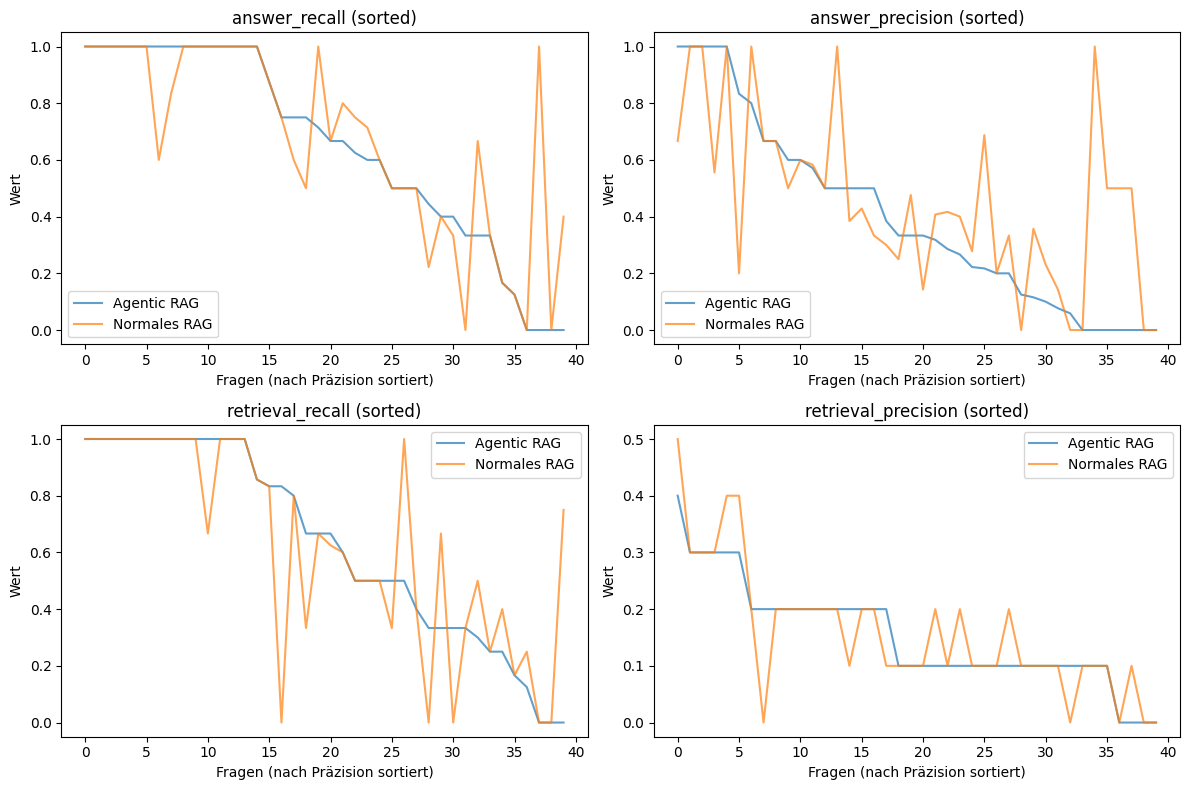

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# import data
df_agentic_rag = pd.read_csv("rag_runs/2025-09-09/df_agentic.csv", index_col=False).drop(columns=["Unnamed: 0"])
df_plain_rag   = pd.read_csv("rag_runs/2025-09-09/df_plain_rag.csv", index_col=False).drop(columns=["Unnamed: 0"])

columns = df_agentic_rag.columns  

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, col in enumerate(columns):
    ax = axes[i//2, i%2]

    # sort both series by agentic metric value (descending)
    order = df_agentic_rag[col].sort_values(ascending=False).index
    agentic_sorted = df_agentic_rag.loc[order, col].reset_index(drop=True)
    plain_sorted   = df_plain_rag.loc[order, col].reset_index(drop=True)

    ax.plot(agentic_sorted.index, agentic_sorted, label="Agentic RAG", alpha=0.7)
    ax.plot(plain_sorted.index, plain_sorted, label="Normales RAG", alpha=0.7)

    ax.set_title(f"{col} (sorted)")
    ax.set_xlabel("Fragen (nach Präzision sortiert)")
    ax.set_ylabel("Wert")
    ax.legend()

plt.tight_layout()
plt.show()

